### Master of Applied Artificial Intelligence

**Course: TC4033 - Computational Vision for Images and Video**

<img src="./../assets/logo.png" alt="Image Alt Text" width="500"/>

**Image enhancement algorithms in the Fourier domain**

Tutor: Dr. Gilberto Ochoa


Team members:
* Alfonso de Lucas Espinosa - A01795118
* Ignacio Jose Aguilar Garcia - A00819762
* Alejandro Calderon Aguilar - A01795353
* Ricardo Mar Cupido - A01795394
* Mario Fonseca Martinez - A01795228


### Introduction

The Fourier transform is a mathematical formula that transforms a signal sampled in time or space to the same signal sampled in temporal or spatial frequency. In signal processing, the Fourier transform can reveal important characteristics of a signal, namely, its frequency components. The Fourier transform is widely used in many fields, including physics, engineering, and computer science.

In this project, we will explore the Fourier transform and its applications in image processing. We will implement several image enhancement algorithms in the Fourier domain, including low-pass filtering and high-pass filtering.

### Fourier Transform
The Fourier transform is a mathematical operation that transforms a signal from the time or spatial domain to the frequency domain. The Fourier transform of a signal \( x \) is defined as:

\begin{equation}
X(f) = \sum_{n=0}^{N-1} x(n) e^{-j2\pi fn/N}
\end{equation}

where \( X(f) \) is the Fourier transform of \( x \) at frequency \( f \), \( x(n) \) is the \( n \)-th sample of \( x \), and \( N \) is the number of samples in \( x \). The Fourier transform can be computed efficiently using the Fast Fourier Transform (FFT) algorithm.

Essentially, the Fourier transform decomposes a signal into its frequency components. The magnitude of the Fourier transform represents the amplitude of each frequency component, while the phase of the Fourier transform represents the phase shift of each frequency component.

<img src="https://www.projectrhea.org/rhea/images/0/01/Cameraman.jpg" alt="Image Alt Text" width="500"/>

### Image Enhancement in the Fourier Domain
The Fourier transform can be applied to images to enhance their quality. For example, low-pass filtering can be used to remove high-frequency noise from an image, while high-pass filtering can be used to enhance the edges of an image.

In fourier domain, we can apply filters to the image to enhance or remove certain frequencies. The filters can be of different types, such as ideal, gaussian or butterworth filters.

### ideal filter
The ideal filter is a simple filter that removes high-frequency noise from an image. The ideal filter is defined as:

\begin{equation}
H(f) = \begin{cases}
1 & \text{if } f \leq f_c \\
0 & \text{if } f > f_c
\end{cases}
\end{equation}

where \( H(f) \) is the ideal filter at frequency \( f \) and \( f_c \) is the cutoff frequency of the filter. The ideal filter removes all frequency components above the cutoff frequency, resulting in a smoother image.

### Gaussian filter
The Gaussian filter is a more sophisticated filter that removes high-frequency noise from an image. The Gaussian filter is defined as:

\begin{equation}
H(f) = e^{-\frac{f^2}{2\sigma^2}}
\end{equation}

where \( H(f) \) is the Gaussian filter at frequency \( f \) and \( \sigma \) is the standard deviation of the filter. The Gaussian filter removes high-frequency noise from an image while preserving the edges of the image.

### butterworth filter
The Butterworth filter is a filter that removes high-frequency noise from an image. The Butterworth filter is defined as:

\begin{equation}
H(f) = \frac{1}{1 + (\frac{f}{f_c})^{2n}}
\end{equation}

where \( H(f) \) is the Butterworth filter at frequency \( f \), \( f_c \) is the cutoff frequency of the filter, and \( n \) is the order of the filter. The Butterworth filter removes high-frequency noise from an image while preserving the edges of the image.

https://www.mathworks.com/help/matlab/math/fourier-transforms.html

https://biomedpharmajournal.org/vol7no2/image-sharpening-by-gaussian-and-butterworth-high-pass-filter/



### Importing libraries

In [9]:
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

### Loading Images

In [10]:
# Loading images

fingerprint = cv2.imread("data/fingerprint.png")
fingerprint_image = cv2.cvtColor(fingerprint, cv2.COLOR_BGR2GRAY)

In [11]:
def plot_images(images=[], labels=[], nrows=1, ncols=2, figsize=(12,8), cmap="gray"):
    """
    Plots a list of images in a grid layout using Matplotlib.

    Parameters:
    images (list): List of images to be plotted.
    labels (list): List of labels for each image. Default is an empty list.
    nrows (int): Number of rows in the grid. Default is 1.
    ncols (int): Number of columns in the grid. Default is 2.
    figsize (tuple): Size of the figure in inches. Default is (12, 8).
    cmap (str): Colormap to be used for displaying the images. Default is "gray".

    Returns:
    None
    """

    # set the subplots
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    # Iterate over each axis defined in M*N as flat
    for i, ax in enumerate(axs.flat):
        # validates that the dimensions of axs fits with images array parameter
        if i < len(images):
            # plot the image
            ax.imshow(images[i], cmap=cmap)
            # if there are labels defined then set a title
            if len(labels) > 0:
                ax.set_title(labels[i])
            # dont show the axis ticks
            ax.axis("off")
        else:
            # dont show an empty plot
            ax.axis("off")
    # fits the plots
    plt.tight_layout()
    plt.show()


### 1. Application of image enhancement using Fourier transform with a low-pass filter.

### Application of image enhancement using Fourier transform with a high-pass filter.
A low-pass filter is a filter that removes high-frequency noise from an image. The low-pass filter is defined as:

\begin{equation}
H(f) = \begin{cases}
0 & \text{if } f \leq f_c \\
1 & \text{if } f > f_c
\end{cases}
\end{equation}

where \( H(f) \) is the low-pass filter at frequency \( f \) and \( f_c \) is the cutoff frequency of the filter. The low-pass filter removes all frequency components above the cutoff frequency, resulting in a smoother image.


low-pass filter: https://www.mathworks.com/help/matlab/ref/lowpass.html




In [12]:
def low_pass_filter(image, filter_type='none', D0=30, n=2):
    """
    Applies a low-pass filter to an image using Fourier transform.

    Parameters:
    image (numpy.ndarray): Input grayscale image.
    filter_type (str): Type of low-pass filter ('none', 'ideal', 'butterworth', 'gaussian').
    D0 (int): Cutoff frequency.
    n (int): Order of the Butterworth filter (only used if filter_type is 'butterworth').

    Returns:
    numpy.ndarray: Filtered image.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    
    # Apply Fourier transform
    dft = np.fft.fft2(image)    
    dft_shift = np.fft.fftshift(dft)

    # Check the filter type and return the fourier transformed image if 'none'
    if filter_type == 'none':
        return np.abs(dft_shift)
    
    # Create the low-pass filter
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols), np.float32)
    
    if filter_type == 'ideal':
        for i in range(rows):
            for j in range(cols):
                if np.sqrt((i - crow)**2 + (j - ccol)**2) <= D0:
                    mask[i, j] = 1
    elif filter_type == 'butterworth':
        for i in range(rows):
            for j in range(cols):
                mask[i, j] = 1 / (1 + (np.sqrt((i - crow)**2 + (j - ccol)**2) / D0)**(2 * n))
    elif filter_type == 'gaussian':
        for i in range(rows):
            for j in range(cols):
                mask[i, j] = np.exp(-((i - crow)**2 + (j - ccol)**2) / (2 * (D0**2)))

    # Apply the filter
    dft_shift_filtered = dft_shift * mask
    
    # Inverse Fourier transform
    dft_shift_filtered = np.fft.ifftshift(dft_shift_filtered)
    img_back = np.fft.ifft2(dft_shift_filtered)
    img_back = np.abs(img_back)
    
    return img_back


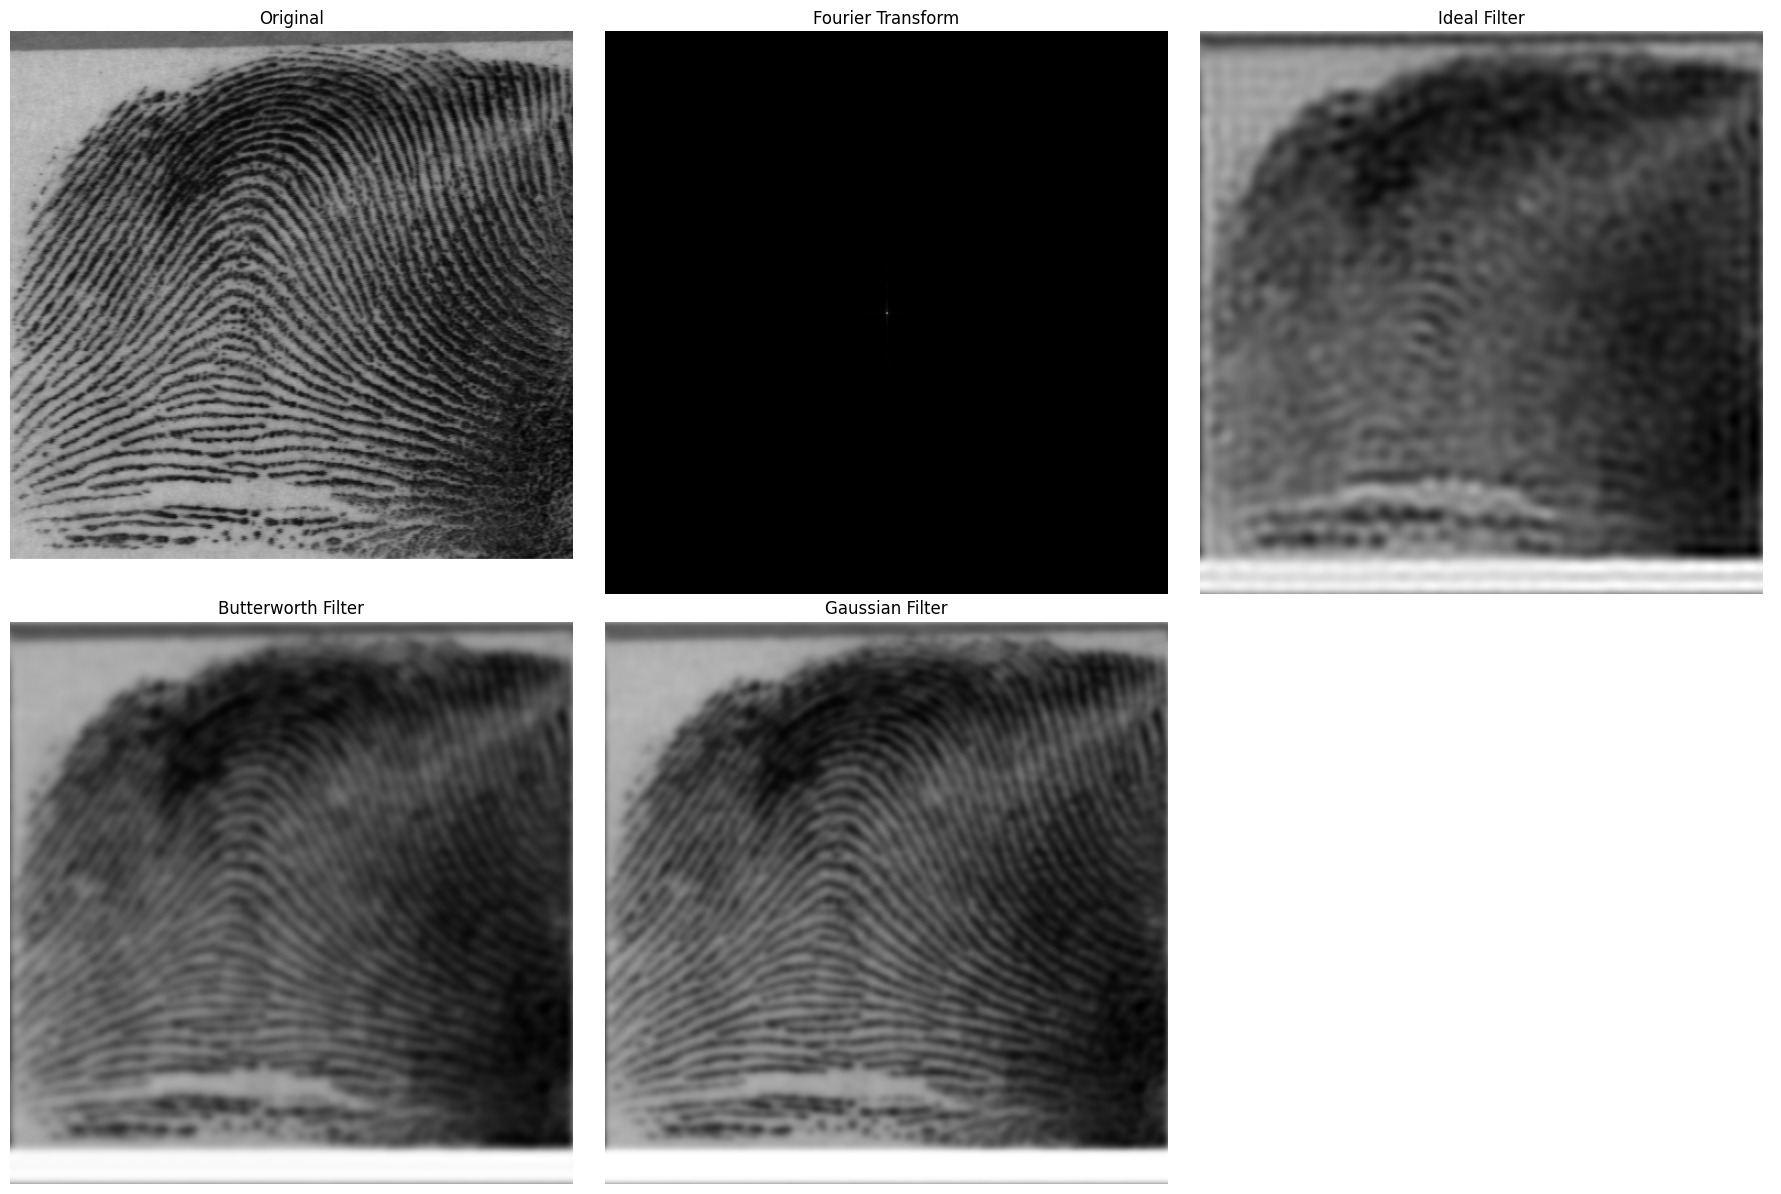

In [13]:
# Load the image
image = fingerprint_image.copy()

# Apply the filters
fourier_low_pass = low_pass_filter(image, filter_type='none')
ideal_filtered = low_pass_filter(image, filter_type='ideal', D0=30)
butterworth_filtered = low_pass_filter(image, filter_type='butterworth', D0=30, n=2)
gaussian_filtered = low_pass_filter(image, filter_type='gaussian', D0=30)


# Display the images
images = [image, fourier_low_pass, ideal_filtered, butterworth_filtered, gaussian_filtered]
labels = ["Original", "Fourier Transform", "Ideal Filter", "Butterworth Filter", "Gaussian Filter"]
plot_images(images, labels, nrows=2, ncols=3, figsize=(18, 12))

### 2. Application of image enhancement using Fourier transform with a high-pass filter.

In [14]:
# Function to apply high-pass filter
def high_pass_filter(image, filter_type='none', D0=30, n=2):
    """
    Applies a high-pass filter to an image using Fourier transform.

    Parameters:
    image (numpy.ndarray): Input grayscale image.
    filter_type (str): Type of high-pass filter ('none', 'ideal', 'butterworth', 'gaussian').
    D0 (int): Cutoff frequency.
    n (int): Order of the Butterworth filter (only used if filter_type is 'butterworth').

    Returns:
    numpy.ndarray: Filtered image.
    """
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)     
    
    # Apply Fourier transform
    dft = np.fft.fft2(image)
    dft_shift = np.fft.fftshift(dft)

    # Check the filter type and return the fourier transformed image if 'none'
    if filter_type == 'none':
        return np.abs(dft_shift)
    
    # Create the high-pass filter
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.float32)
    if filter_type == 'ideal':
        for i in range(rows):
            for j in range(cols):
                if np.sqrt((i - crow)**2 + (j - ccol)**2) <= D0:
                    mask[i, j] = 0
    elif filter_type == 'butterworth':
        for i in range(rows):
            for j in range(cols):
                distance = np.sqrt((i - crow)**2 + (j - ccol)**2)
                if distance == 0:
                    mask[i, j] = 0
                else:
                    mask[i, j] = 1 / (1 + (D0 / distance)**(2 * n))
    elif filter_type == 'gaussian':
        for i in range(rows):
            for j in range(cols):
                mask[i, j] = 1 - np.exp(-((i - crow)**2 + (j - ccol)**2) / (2 * (D0**2)))
    
    # Apply the filter
    dft_shift_filtered = dft_shift * mask
    
    # Inverse Fourier transform
    dft_shift_filtered = np.fft.ifftshift(dft_shift_filtered)
    img_back = np.fft.ifft2(dft_shift_filtered)
    img_back = np.abs(img_back)
    
    return img_back

In [15]:
# Load the image
image = fingerprint_image.copy()

# Apply the filters
fourier_high_pass = high_pass_filter(image, filter_type='none')
ideal_filtered = high_pass_filter(image, filter_type='ideal', D0=30)
butterworth_filtered = high_pass_filter(image, filter_type='butterworth', D0=30, n=2)
gaussian_filtered = high_pass_filter(image, filter_type='gaussian', D0=30)


# Display the images
images = [image, fourier_high_pass_magnitude, ideal_filtered, butterworth_filtered, gaussian_filtered]
labels = ["Original", "Fourier Transform", "Ideal Filter", "Butterworth Filter", "Gaussian Filter"]
plot_images(images, labels, nrows=2, ncols=3, figsize=(18, 12))

NameError: name 'fourier_high_pass_magnitude' is not defined

### Conclusion

### References
